# EECS289 Final Project: Explainable NLP for Multiclass Review Rating Prediction
Team members: Tian Herng Tan (tth@berkeley.edu), Yilin Wang (yilinw25@berkeley.edu), Stephen Tao (stephen_tao@berkeley.edu)

## **1. Download dataset from [Kaggle](https://www.kaggle.com/api/v1/datasets/download/snap/amazon-fine-food-reviews)**

In [ ]:
!curl -L -o ./amazon-fine-food-reviews.zip https://www.kaggle.com/api/v1/datasets/download/snap/amazon-fine-food-reviews


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  242M  100  242M    0     0  19.5M      0  0:00:12  0:00:12 --:--:-- 22.6M


## **2. Extract zip file**

In [ ]:
import zipfile
with zipfile.ZipFile('./amazon-fine-food-reviews.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

##**3. Learning how the data looks like**

In [ ]:
# imports
# !pip -q install imbalanced-learn
!pip -q install nltk
from pathlib import Path
import json, os, time, math, random

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import loguniform

import matplotlib.pyplot as plt
import joblib
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# reproducibility
def set_seed(s=42):
    random.seed(s); np.random.seed(s)
set_seed(42)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Shape of data: (568454, 10)
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of t

<Axes: xlabel='Score'>

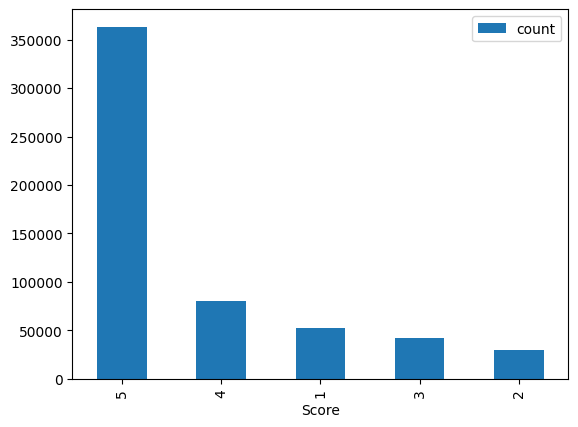

In [ ]:
df = pd.read_csv('./Reviews.csv')

print("Shape of data:", df.shape)
print(df.head())
df['Score'].value_counts().plot(kind='bar', legend=True)

In [ ]:
print("Shape:", df.shape)
print(df.columns.tolist()[:15])
df = df[['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator',
         'Score','Time','Summary','Text']].copy()

# keep valid scores and non-null text
df = df[df['Score'].between(1,5)]
df = df.dropna(subset=['Text'])
df['Score'] = df['Score'].astype(int)
df['Summary'] = df['Summary'].fillna("")

# combine text + summary
df['text_full'] = (df['Summary'].astype(str) + " " + df['Text'].astype(str)).str.strip()

# convert time (unix) -> datetime
df['Time'] = pd.to_datetime(df['Time'], unit='s', errors='coerce')

print("After cleaning:", df.shape)
df.head(3)

Shape: (568454, 14)
['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text', 'user_review_count', 'user_avg_rating', 'user_rating_std', 'help_ratio']
After cleaning: (568454, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,text_full
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,Good Quality Dog Food I have bought several of...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised Product arrived labeled as J...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,"""Delight"" says it all This is a confection tha..."


## **4. Create baseline model**

In [ ]:
# imports
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# baseline df
baseline_df = df.copy()
X = baseline_df['Text'].values
y = baseline_df['Score'].astype(int).values

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
)

# fit tfidf on training text
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=200_000,
    min_df=2,
    max_df=0.98,
    stop_words='english',
    lowercase=True
)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

# apply logistic regression
logreg = LogisticRegression(
    solver='saga',
    max_iter=1000,
    n_jobs=-1,
    class_weight='balanced',
    multi_class='multinomial'
)
logreg.fit(X_train, y_train)

# evaluation
y_pred = logreg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy:   {acc:.4f}")
print(f"Macro F1:   {macro_f1:.4f}")

cm = confusion_matrix(y_test, y_pred, labels=[1,2,3,4,5])
cm_df = pd.DataFrame(cm, index=[f"true_{i}" for i in [1,2,3,4,5]],
                        columns=[f"pred_{i}" for i in [1,2,3,4,5]])
print("\nConfusion Matrix (rows=true, cols=pred):")
print(cm_df)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy:   0.7136
Macro F1:   0.5961

Confusion Matrix (rows=true, cols=pred):
        pred_1  pred_2  pred_3  pred_4  pred_5
true_1    8003    1276     712     124     211
true_2    1135    3304    1078     190     148
true_3     715    1216    5313     832     409
true_4     552     825    2590    9105    3051
true_5    2199    2032    4232    9036   55403


## **5. Basic review statistics (clean & helpfulness)**

In [ ]:
def safe_ratio(a, b):
    return np.where(b>0, a/np.clip(b, 1, None), 0.0)

# helpfulness ratio and simple lengths
df['help_ratio'] = safe_ratio(df['HelpfulnessNumerator'].fillna(0).astype(float),
                              df['HelpfulnessDenominator'].fillna(0).astype(float))
df['word_len'] = df['text_full'].str.split().apply(len).astype(int)
df['char_len'] = df['text_full'].str.len().astype(int)

# sentiment (VADER)
sent = df['text_full'].map(lambda t: sia.polarity_scores(str(t))['compound'])
df['sentiment'] = sent.astype(float)

# recency feature (days since min date; robust if time missing)
min_t = df['Time'].min()
df['review_age_days'] = (df['Time'] - min_t).dt.days.fillna(0).astype(float)

df[['Score','help_ratio','word_len','char_len','sentiment','review_age_days']].describe()

,Score,help_ratio,word_len,char_len,sentiment,review_age_days
count,568454.000000,568454.000000,568454.000000,568454.000000,568454.000000,568454.000000
mean,4.183199,0.407862,84.377125,460.667780,0.690862,4130.969964
std,1.310436,0.462068,80.253687,449.843623,0.474480,556.056856
min,1.000000,0.000000,4.000000,23.000000,-0.999400,0.000000
25%,4.000000,0.000000,37.000000,200.000000,0.698800,3842.000000
50%,5.000000,0.000000,60.000000,325.000000,0.902000,4303.000000
75%,5.000000,1.000000,102.000000,554.000000,0.958300,4553.000000
max,5.000000,3.000000,3451.000000,21535.000000,0.999900,4767.000000


## **6. Feature Engineering**

In [ ]:
# user aggregates
user_grp = df.groupby('UserId')
df['user_review_count']   = user_grp['Id'].transform('count')
df['user_avg_rating']     = user_grp['Score'].transform('mean')
df['user_rating_std']     = user_grp['Score'].transform('std').fillna(0.0)
df['user_help_avg']       = user_grp['help_ratio'].transform('mean')

# product aggregates
prod_grp = df.groupby('ProductId')
df['prod_review_count']   = prod_grp['Id'].transform('count')
df['prod_avg_rating']     = prod_grp['Score'].transform('mean')
df['prod_rating_std']     = prod_grp['Score'].transform('std').fillna(0.0)
df['prod_help_avg']       = prod_grp['help_ratio'].transform('mean')
df['prod_wordlen_avg']    = prod_grp['word_len'].transform('mean')

numeric_features = [
    'help_ratio','word_len','char_len','sentiment','review_age_days',
    'user_review_count','user_avg_rating','user_rating_std','user_help_avg',
    'prod_review_count','prod_avg_rating','prod_rating_std','prod_help_avg','prod_wordlen_avg'
]

print("Numeric features:", len(numeric_features))
df[numeric_features].head(3)

Numeric features: 14


,help_ratio,word_len,char_len,sentiment,review_age_days,user_review_count,user_avg_rating,user_rating_std,user_help_avg,prod_review_count,prod_avg_rating,prod_rating_std,prod_help_avg,prod_wordlen_avg
0,1.0,52,285,0.9583,4219.0,1,5.000000,0.00000,1.000000,1,5.0,0.0,1.0,52.0
1,0.0,34,208,-0.5664,4718.0,1,1.000000,0.00000,0.000000,1,1.0,0.0,0.0,34.0
2,1.0,98,531,0.8265,3237.0,3,4.333333,0.57735,0.333333,1,4.0,0.0,1.0,98.0


In [ ]:
print("Shape:", df.shape)
print(df.columns.tolist()[:20])

Shape: (568454, 25)
['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text', 'text_full', 'help_ratio', 'word_len', 'char_len', 'sentiment', 'review_age_days', 'user_review_count', 'user_avg_rating', 'user_rating_std', 'user_help_avg']


## **7. Baseline Model + early valuation**

In [ ]:
data = df[['Score','text_full'] + numeric_features].copy()
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['Score']),
    data['Score'].astype(int),
    test_size=0.20, stratify=data['Score'].astype(int),
    random_state=42
)
X_train.shape, X_test.shape

((454763, 15), (113691, 15))

In [ ]:
text_col = 'text_full'

preprocess = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(
            ngram_range=(1,2),
            max_features=200_000,
            min_df=2,
            max_df=0.98,
            stop_words='english',
            lowercase=True
        ), text_col),
        ('num', StandardScaler(with_mean=False), numeric_features)
    ],
    remainder='drop',
    sparse_threshold=0.3  # keep sparse when possible
)

clf = LogisticRegression(
    solver='saga',
    max_iter=1000,
    n_jobs=-1,
    class_weight='balanced',
    multi_class='multinomial',
    C=1.0
)

pipe = Pipeline([('prep', preprocess), ('clf', clf)])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Baseline — Accuracy: {acc:.4f} | Macro-F1: {macro_f1:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Baseline — Accuracy: 0.8515 | Macro-F1: 0.7715


In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = {'acc':'accuracy', 'f1':'f1_macro'}
cv_res = cross_validate(pipe, data.drop(columns=['Score']), data['Score'].astype(int),
                        cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
print("CV Accuracy:", cv_res['test_acc'].mean().round(4), "+/-", cv_res['test_acc'].std().round(4))
print("CV Macro-F1:", cv_res['test_f1'].mean().round(4), "+/-", cv_res['test_f1'].std().round(4))

CV Accuracy: 0.8494 +/- 0.0035
CV Macro-F1: 0.7677 +/- 0.0029


## **8. Hyperparameter search**

In [ ]:
# Build a ~100k stratified subset from X_train/y_train for quick hyperparam search
SEARCH_SIZE = 100_000

tmp = X_train.copy()
tmp['Score'] = y_train.values

sub = tmp.groupby('Score', group_keys=False).apply(
    lambda t: t.sample(min(len(t), SEARCH_SIZE // 5), random_state=42)
).sample(frac=1.0, random_state=42)  # shuffle

X_search = sub.drop(columns=['Score'])
y_search = sub['Score'].astype(int)

X_search.shape, y_search.value_counts().sort_index()

/tmp/ipython-input-2049954458.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sub = tmp.groupby('Score', group_keys=False).apply(


((100000, 15),
 Score
 1    20000
 2    20000
 3    20000
 4    20000
 5    20000
 Name: count, dtype: int64)

In [ ]:
from tempfile import mkdtemp
from joblib import Memory
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import loguniform

# Cached preprocessing (avoids recomputing TF-IDF every CV fold)
cachedir = mkdtemp()

preprocess_fast = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(
            ngram_range=(1,1),        # faster during search
            max_features=100_000,
            min_df=5,
            max_df=0.95,
            stop_words='english',
            lowercase=True
        ), 'text_full'),
        ('num', StandardScaler(with_mean=False), numeric_features)
    ],
    remainder='drop'
)

clf_fast = LogisticRegression(
    solver='saga',
    max_iter=500,
    n_jobs=-1,
    class_weight='balanced',
    multi_class='multinomial'
)

pipe_fast = Pipeline(
    steps=[('prep', preprocess_fast), ('clf', clf_fast)],
    memory=Memory(location=cachedir, verbose=0)
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_dist_fast = {'clf__C': loguniform(1e-2, 10)}

search_fast = RandomizedSearchCV(
    pipe_fast,
    param_distributions=param_dist_fast,
    n_iter=8,                 # small, fast search
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search_fast.fit(X_search, y_search)
print("Fast search — best CV Macro-F1:", round(search_fast.best_score_, 4))
print("Best params:", search_fast.best_params_)

best_C = search_fast.best_params_['clf__C']
best_C

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fast search — best CV Macro-F1: 0.747
Best params: {'clf__C': np.float64(0.13292918943162169)}


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


np.float64(0.13292918943162169)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Final — Accuracy: 0.8439
Final — Macro-F1: 0.7616


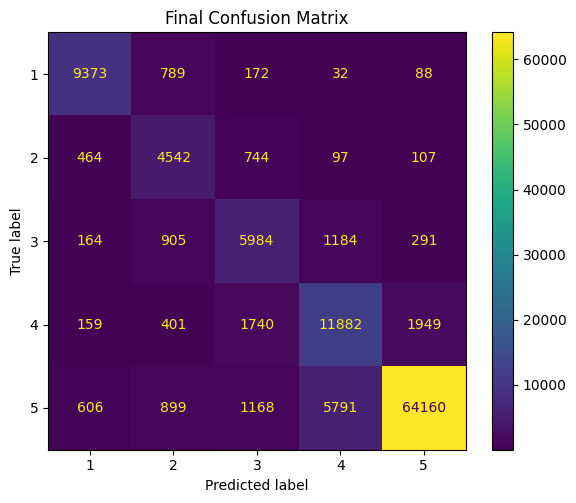

              precision    recall  f1-score   support

           1      0.871     0.897     0.883     10454
           2      0.603     0.763     0.673      5954
           3      0.610     0.702     0.653      8528
           4      0.626     0.737     0.677     16131
           5      0.963     0.883     0.922     72624

    accuracy                          0.844    113691
   macro avg      0.735     0.796     0.762    113691
weighted avg      0.862     0.844     0.850    113691



In [ ]:
# Stronger text settings for final training
preprocess_final = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(
            ngram_range=(1,2),        # restore bigrams
            max_features=200_000,     # larger vocab
            min_df=2,
            max_df=0.98,
            stop_words='english',
            lowercase=True
        ), 'text_full'),
        ('num', StandardScaler(with_mean=False), numeric_features)
    ],
    remainder='drop'
)

clf_final = LogisticRegression(
    solver='saga',
    max_iter=1000,
    n_jobs=-1,
    class_weight='balanced',
    multi_class='multinomial',
    C=best_C
)

pipe_final = Pipeline([('prep', preprocess_final), ('clf', clf_final)])
pipe_final.fit(X_train, y_train)

y_pred_final = pipe_final.predict(X_test)

print("Final — Accuracy:", round(accuracy_score(y_test, y_pred_final),4))
print("Final — Macro-F1:", round(f1_score(y_test, y_pred_final, average='macro'),4))

# Optional: confusion matrix + report
fig, ax = plt.subplots(figsize=(6,5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_final, labels=[1,2,3,4,5], ax=ax)
plt.title("Final Confusion Matrix")
plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred_final, digits=3))

## Draft:

In [ ]:
from tempfile import mkdtemp
from joblib import Memory
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# cached pipeline so TF-IDF isn't recomputed each CV fold
cachedir = mkdtemp()

preprocess_full = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(
            ngram_range=(1,2),
            max_features=200_000,
            min_df=2,
            max_df=0.98,
            stop_words='english',
            lowercase=True
        ), 'text_full'),
        ('num', StandardScaler(with_mean=False), numeric_features)
    ],
    remainder='drop'
)

clf_full = LogisticRegression(
    solver='saga',
    max_iter=1000,
    n_jobs=-1,
    class_weight='balanced',
    multi_class='multinomial',
    C=1.0  # will be overridden by grid
)

pipe_full = Pipeline(
    steps=[('prep', preprocess_full), ('clf', clf_full)],
    memory=Memory(location=cachedir, verbose=0)
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_grid = {'clf__C': [0.25, 0.5, 1.0, 2.0, 4.0]}

grid = GridSearchCV(
    estimator=pipe_full,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

grid.fit(X_train, y_train)

print("Grid best CV Macro-F1:", round(grid.best_score_, 4))
print("Best params:", grid.best_params_)

# show per-C CV scores (sorted)
cv_table = (
    pd.DataFrame(grid.cv_results_)[['param_clf__C','mean_test_score','std_test_score']]
      .sort_values('param_clf__C')
)
cv_table

NameError: name 'ColumnTransformer' is not defined

In [ ]:
best_C = grid.best_params_['clf__C']
best_model = grid.best_estimator_

y_pred_best = best_model.predict(X_test)
acc_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best, average='macro')

print(f"Test (best C={best_C}) — Accuracy: {acc_best:.4f} | Macro-F1: {f1_best:.4f}")

# Optional: confusion matrix / report
fig, ax = plt.subplots(figsize=(6,5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best, labels=[1,2,3,4,5], ax=ax)
plt.title(f"Confusion Matrix — best C={best_C}")
plt.tight_layout(); plt.show()

print(classification_report(y_test, y_pred_best, digits=3))

# Add feature variants & scaling checks

In [ ]:
# Example extra engineered signals
for col in ['help_ratio','sentiment']:
    df[f'{col}_sq'] = df[col]**2

# refresh sets with the new features
extra_feats = numeric_features + ['help_ratio_sq','sentiment_sq']
data2 = df[['Score','text_full'] + extra_feats].copy()
Xtr, Xte, ytr, yte = train_test_split(
    data2.drop(columns=['Score']),
    data2['Score'].astype(int),
    test_size=0.20, stratify=data2['Score'].astype(int),
    random_state=42
)

preprocess2 = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(ngram_range=(1,2),
                                  max_features=200_000, min_df=2, max_df=0.98,
                                  stop_words='english', lowercase=True), 'text_full'),
        ('num', StandardScaler(with_mean=False), extra_feats)
    ],
    remainder='drop'
)

pipe2 = Pipeline([('prep', preprocess2),
                  ('clf', LogisticRegression(solver='saga', max_iter=1000, n_jobs=-1,
                                             class_weight='balanced', multi_class='multinomial', C=search.best_params_.get('clf__C',1.0)))])
pipe2.fit(Xtr, ytr)
pred2 = pipe2.predict(Xte)
print("Enhanced — Accuracy:", round(accuracy_score(yte, pred2),4))
print("Enhanced — Macro-F1:", round(f1_score(yte, pred2, average='macro'),4))

# Error analysis

In [ ]:
proba = best_model.predict_proba(X_test)
err_df = pd.DataFrame({
    "true": y_test.values,
    "pred": y_pred_best,
    "max_conf": proba.max(axis=1)
})
# add raw text for inspection
err_df = err_df.join(X_test[[ 'text_full' ]].reset_index(drop=True))

# biggest mistakes: wrong + high confidence
hard = err_df[err_df.true != err_df.pred].sort_values("max_conf", ascending=False).head(20)
hard[['true','pred','max_conf','text_full']].head(10)

# Class distribution plot (quick check)

In [ ]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar', figsize=(5,4))
ax.set_xlabel("Score"); ax.set_ylabel("Count"); ax.set_title("Class distribution")
plt.tight_layout(); plt.show()